[*********************100%%**********************]  1 of 1 completed


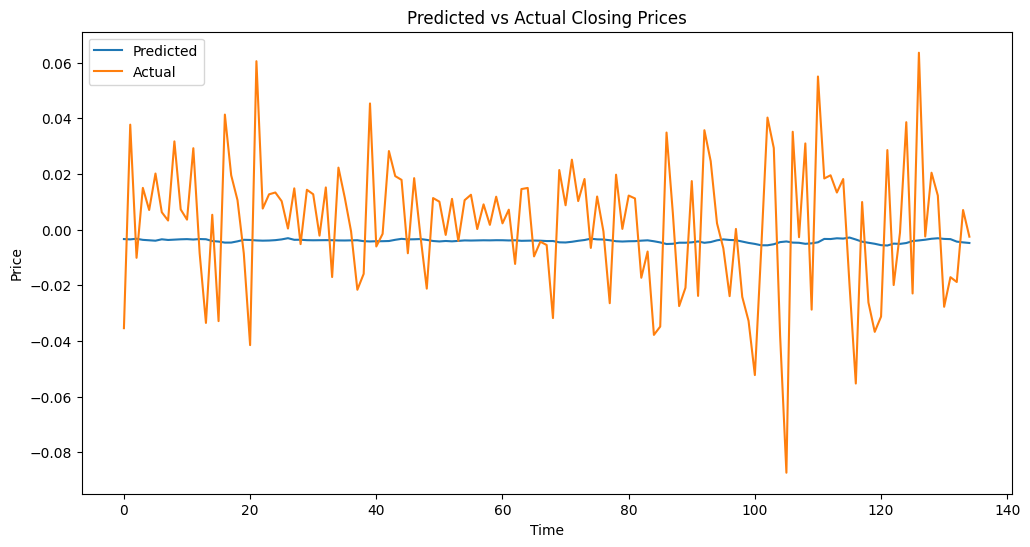

Window Size: 5, Test Loss: 0.007454701699316502


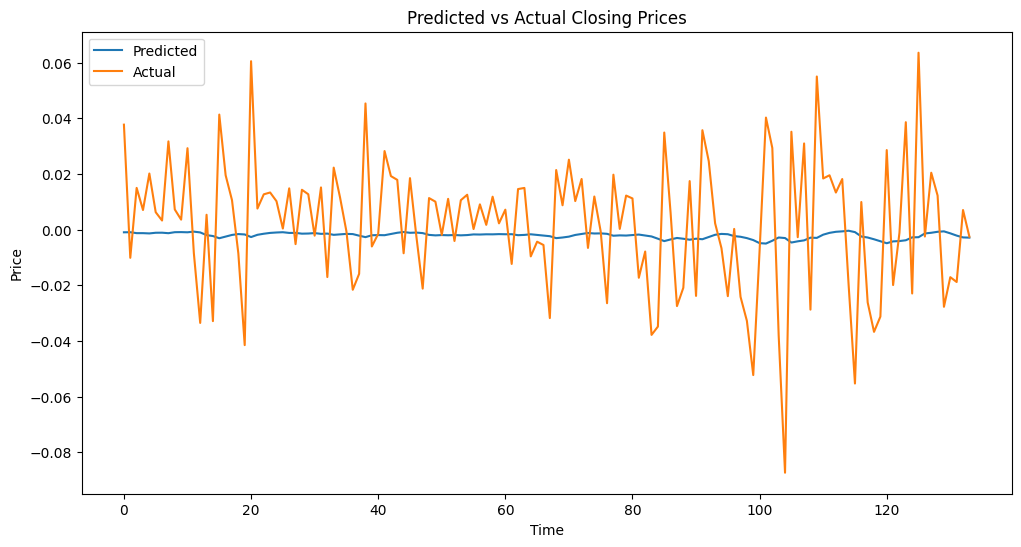

Window Size: 10, Test Loss: 0.007198775187134743


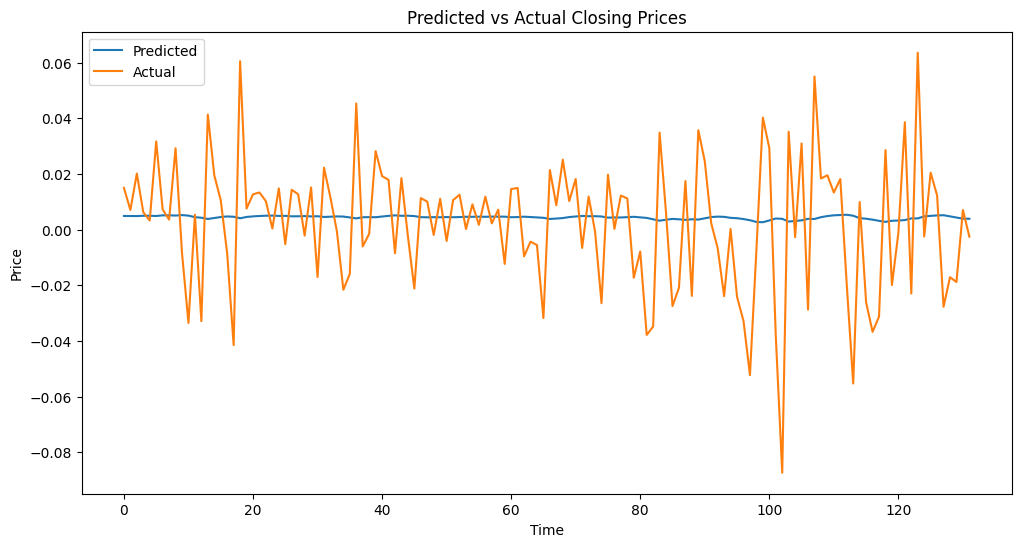

Window Size: 20, Test Loss: 0.007002716884016991


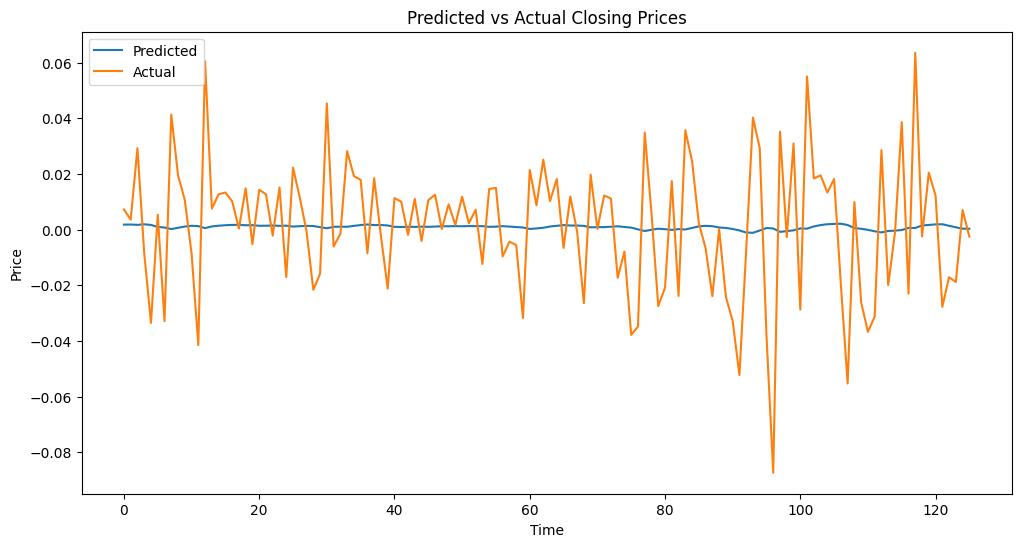

Window Size: 50, Test Loss: 0.007129713427275419


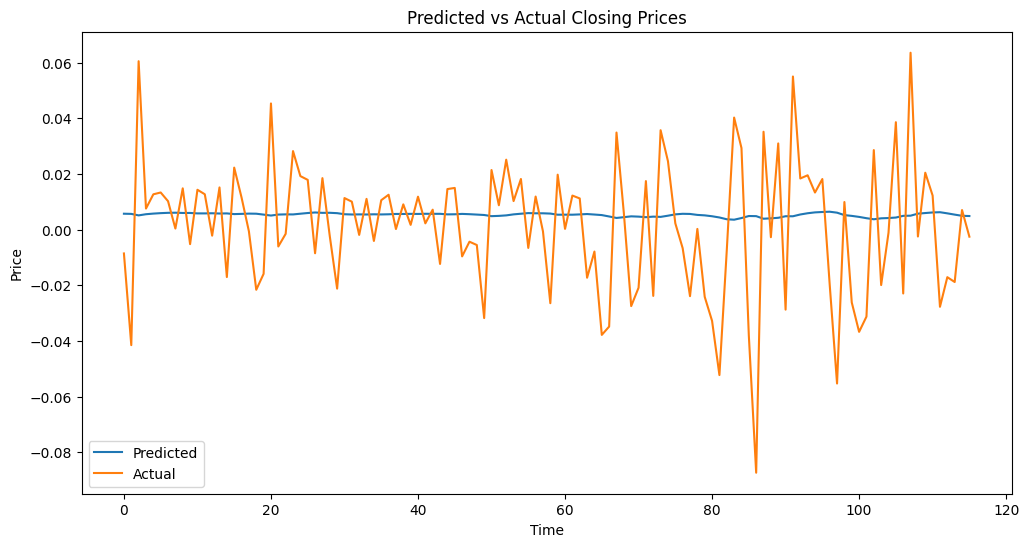

Window Size: 100, Test Loss: 0.007378351408988237


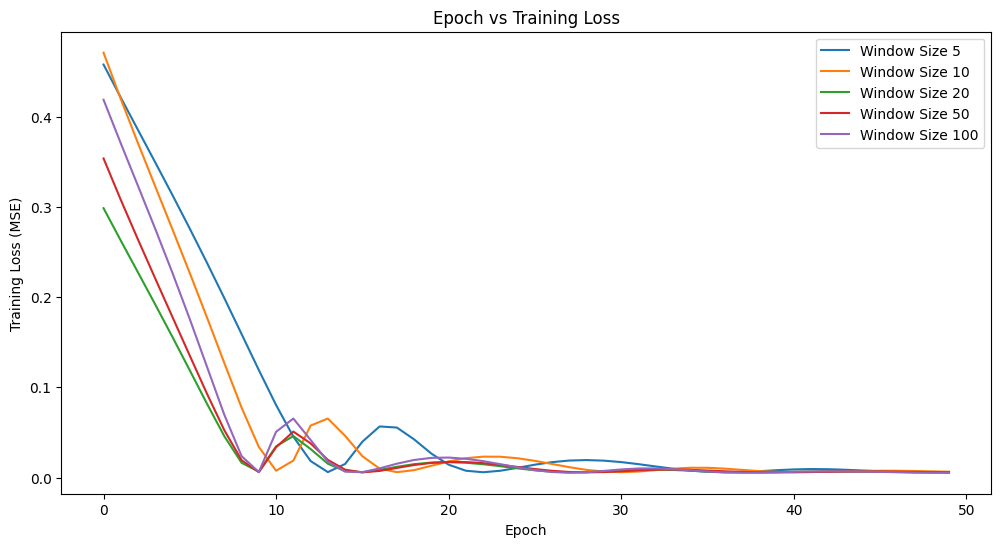

In [8]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# S&P 500 데이터 로드
ticker = '^GSPC'
data = yf.download(ticker, start='2010-01-01', end='2023-01-01',interval='1wk')
data = data[['Close']].pct_change().dropna()   # 종가만 사용

# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# 윈도우 데이터 생성 함수
def create_windowed_data(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size, 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # 마지막 시점의 출력만 사용
        return out

# 모델 학습 및 평가 함수
def train_evaluate_model(window_size):
    X, y = create_windowed_data(scaled_data, window_size)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
    y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
    y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(-1).to(device)

    input_size = 1
    hidden_size = 100
    num_layers = 2
    output_size = 1

    model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # 에포크별 손실 저장을 위한 리스트
    epoch_losses = []

    # 모델 학습
    model.train()
    num_epochs = 50
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())

    # 모델 평가
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test).item()

    # 예측값과 실제값을 비교하여 플롯
    plt.figure(figsize=(12, 6))
    plt.plot(scaler.inverse_transform(test_outputs.cpu().numpy()), label='Predicted')
    plt.plot(scaler.inverse_transform(y_test.cpu().numpy()), label='Actual')
    plt.title('Predicted vs Actual Closing Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    return test_loss, epoch_losses

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 윈도우 크기에 따른 성능 비교
window_sizes = [5, 10, 20, 50, 100]
all_losses = []

for size in window_sizes:
    test_loss, epoch_losses = train_evaluate_model(size)
    print(f'Window Size: {size}, Test Loss: {test_loss}')
    all_losses.append(epoch_losses)

# 에포크별 손실 비교 플롯
plt.figure(figsize=(12, 6))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f'Window Size {window_sizes[i]}')
plt.title('Epoch vs Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Training Loss (MSE)')
plt.legend()
plt.show()